## Experiment #1 results and analysis

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline 

In [2]:
import statsmodels ## version 0.10.1 -- the only version tested
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols, mixedlm
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

This notebook contains the analysis of the data obtained from the first experiment with 293A HEK cells.  
The genetically engineered cells, expressing the ER stress biosensor XBP1-TagRFP, were produced as the model system.  
A group of cells, constantly expressing TagRFP, was used as a positive control.   
The cells with TagRFP expression induced under ER stress conditions are referred as experimental group.   
Cells were counted and the numbers of red cells were obtained with CellCountCV, the percentages of red cells were calculated.  

Read the data table

In [3]:
rslt_ex1 = pd.read_excel('SupplementaryTables1_bioRxiv.xlsx')

In [4]:
rslt_ex1.head() ## the first 5 lines of our data table

,Group,FoV,Date_time,Order,Cells,Red_cells,Red_cells_%
0,RFP+,1,2018-04-11 11:09:12.570,1,280.924970,126.933713,45.184204
1,RFP+,1,2018-04-11 11:24:27.390,2,299.993343,139.619985,46.541028
2,RFP+,1,2018-04-11 11:39:12.720,3,296.750592,134.656583,45.377023
3,RFP+,1,2018-04-11 11:54:12.730,4,304.939941,152.161953,49.898991
4,RFP+,1,2018-04-11 12:09:12.650,5,312.099467,149.821435,48.004387


In [5]:
rslt_ex1['Group'] = pd.Categorical(rslt_ex1.Group.values, ## make it categorical
                                   categories = ['Tu','RFP+','DMSO','Int'] )

In [6]:
## make the data table with initial values subtracted to track the changes
tdf = rslt_ex1[
    ['Red_cells_%', 'Group', 'FoV', 'Order' ]]
tdf = tdf.pivot_table(index=['Group', 'FoV'], columns='Order')
tdf_red = (tdf.T - tdf.iloc[:,0]).T.stack().reset_index() ## the changes in Red_cells_%

tdf = rslt_ex1[
    ['Cells', 'Group', 'FoV', 'Order' ]]
tdf = tdf.pivot_table(index=['Group', 'FoV'], columns='Order')
tdf_cells = (tdf.T - tdf.iloc[:,0]).T.stack().reset_index()  ## the changes in total cell counts


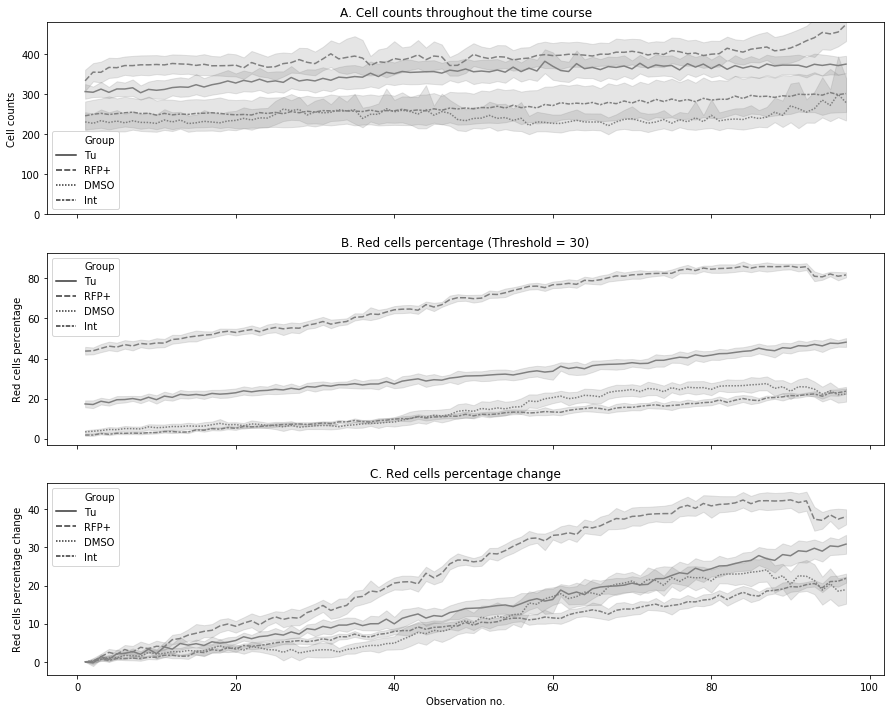

In [7]:
## The illustration from paper
_, axs = plt.subplots(nrows = 3, figsize = (15, 12), sharex = True)
sns.lineplot(data = rslt_ex1, x = 'Order', style = 'Group', color = '#808080', y = 'Cells', ax = axs[0])
sns.lineplot(data = rslt_ex1, x = 'Order', style = 'Group', color = '#808080', y = 'Red_cells_%', ax = axs[1])
sns.lineplot(data = tdf_red, x = 'Order', style = 'Group', color = '#808080', y = 'Red_cells_%', ax = axs[2])
axs[0].set_title('A. Cell counts throughout the time course')
axs[0].set_ylim([0, 480])
axs[0].set_ylabel('Cell counts')
axs[1].set_title('B. Red cells percentage (Threshold = 30)')
axs[1].set_ylabel('Red cells percentage')
axs[2].set_title('C. Red cells percentage change')
axs[2].set_ylabel('Red cells percentage change')
axs[2].set_xlabel('Observation no.');
#?sns.lineplot

In [8]:
## If changes in red cells percentages were significant between the groups
## (Final value - Initial value) in one group vs. another one
tmp = rslt_ex1[['Group','FoV','Order',
                       'Red_cells_%']].melt(id_vars=['Group', 'FoV', 'Order'])
firstone = tmp[tmp.Order == 1 ]
lastone  = tmp[tmp.Order == 97 ]

MultiComp2 = MultiComparison(lastone['value'].values - firstone['value'].values,
                             lastone['Group'])
MultiComp2.allpairtest(stats.mannwhitneyu, method='Bonferroni')[0]

group1,group2,stat,pval,pval_corr,reject
DMSO,Int,35.0,0.1365,0.8191,False
DMSO,RFP+,0.0,0.0001,0.0005,True
DMSO,Tu,3.0,0.0002,0.0013,True
Int,RFP+,0.0,0.0001,0.0005,True
Int,Tu,0.0,0.0001,0.0005,True
RFP+,Tu,8.0,0.0009,0.0051,True


In [9]:
## If Final values in one group are significantly different from another one
tmp = rslt_ex1[['Group','FoV','Order',
                       'Red_cells_%']].melt(id_vars=['Group', 'FoV', 'Order'])
lastone  = tmp[tmp.Order == 97 ]

MultiComp2 = MultiComparison(lastone['value'].values,
                             lastone['Group'])
MultiComp2.allpairtest(stats.mannwhitneyu, method='Bonferroni')[0]

group1,group2,stat,pval,pval_corr,reject
DMSO,Int,49.0,0.4849,1.0,False
DMSO,RFP+,0.0,0.0001,0.0005,True
DMSO,Tu,0.0,0.0001,0.0005,True
Int,RFP+,0.0,0.0001,0.0005,True
Int,Tu,0.0,0.0001,0.0005,True
RFP+,Tu,0.0,0.0001,0.0005,True


In [10]:
## If there is a significant difference in initial values between the groups
tmp = rslt_ex1[['Group','FoV','Order',
                       'Red_cells_%']].melt(id_vars=['Group', 'FoV', 'Order'])
firstone = tmp[tmp.Order == 1 ]
lastone  = tmp[tmp.Order == 97 ]

MultiComp2 = MultiComparison(firstone['value'].values, 
                             firstone['Group'])
MultiComp2.allpairtest(stats.mannwhitneyu, method='Bonferroni')[0]

group1,group2,stat,pval,pval_corr,reject
DMSO,Int,18.0,0.0086,0.0518,False
DMSO,RFP+,0.0,0.0001,0.0005,True
DMSO,Tu,0.0,0.0001,0.0005,True
Int,RFP+,0.0,0.0001,0.0005,True
Int,Tu,0.0,0.0001,0.0005,True
RFP+,Tu,0.0,0.0001,0.0005,True


In [25]:
## prepare the data frames for boxplots
rslt_ex1.loc[rslt_ex1.index, 'Group'] = pd.Categorical(rslt_ex1.Group.astype('str'),# ordered = True,
                                          categories = ['Int','DMSO','Tu','RFP+'] )
rslt_ex1_2 = rslt_ex1.reset_index(drop=True,inplace=False)
rslt_ex1_2.loc[rslt_ex1_2.index, 'Group_fact'] = pd.Categorical(rslt_ex1_2.Group.values, 
                                                 categories = ['Int','DMSO','Tu','RFP+'],
                                                 ordered=False)
rslt_ex1_2.loc[rslt_ex1_2.index, 'order_fact'] = pd.Categorical(rslt_ex1_2.Order.values)
rslt_ex1_2.loc[rslt_ex1_2.index, 'subj_id']    = pd.Categorical( (rslt_ex1['Group'].astype('str') + \
                                                                  '_'+rslt_ex1['FoV'].astype('str')).values )

## for Red_cells_% change (at the 97th time point as compared to the 1st one)
tmp = rslt_ex1_2[rslt_ex1_2.Order == 97]
tmp.loc[tmp.index,'Red_cells_%'] = tmp['Red_cells_%'].values - rslt_ex1_2[rslt_ex1_2.Order == 1]['Red_cells_%'].values

## for the red cells counts at the 97th time point
tmp2 = rslt_ex1_2[rslt_ex1_2.Order == 97]
tmp2.loc[tmp2.index.values, 'Cells'] = tmp2.Cells.values * .01 *\
      rslt_ex1_2[rslt_ex1_2.Order == 97]['Red_cells_%'].values

## for the red cells counts at the 1st time point
tmp4 = rslt_ex1_2[rslt_ex1_2.Order == 1]
tmp4.loc[tmp4.index.values, 'Cells'] = tmp4.Cells.values * .01 *\
      rslt_ex1_2[rslt_ex1_2.Order == 97]['Red_cells_%'].values

## the table with initial counts
tmp_1 = rslt_ex1_2[rslt_ex1_2.Order == 1]
## the table with final counts
tmp_97 = rslt_ex1_2[rslt_ex1_2.Order == 97]

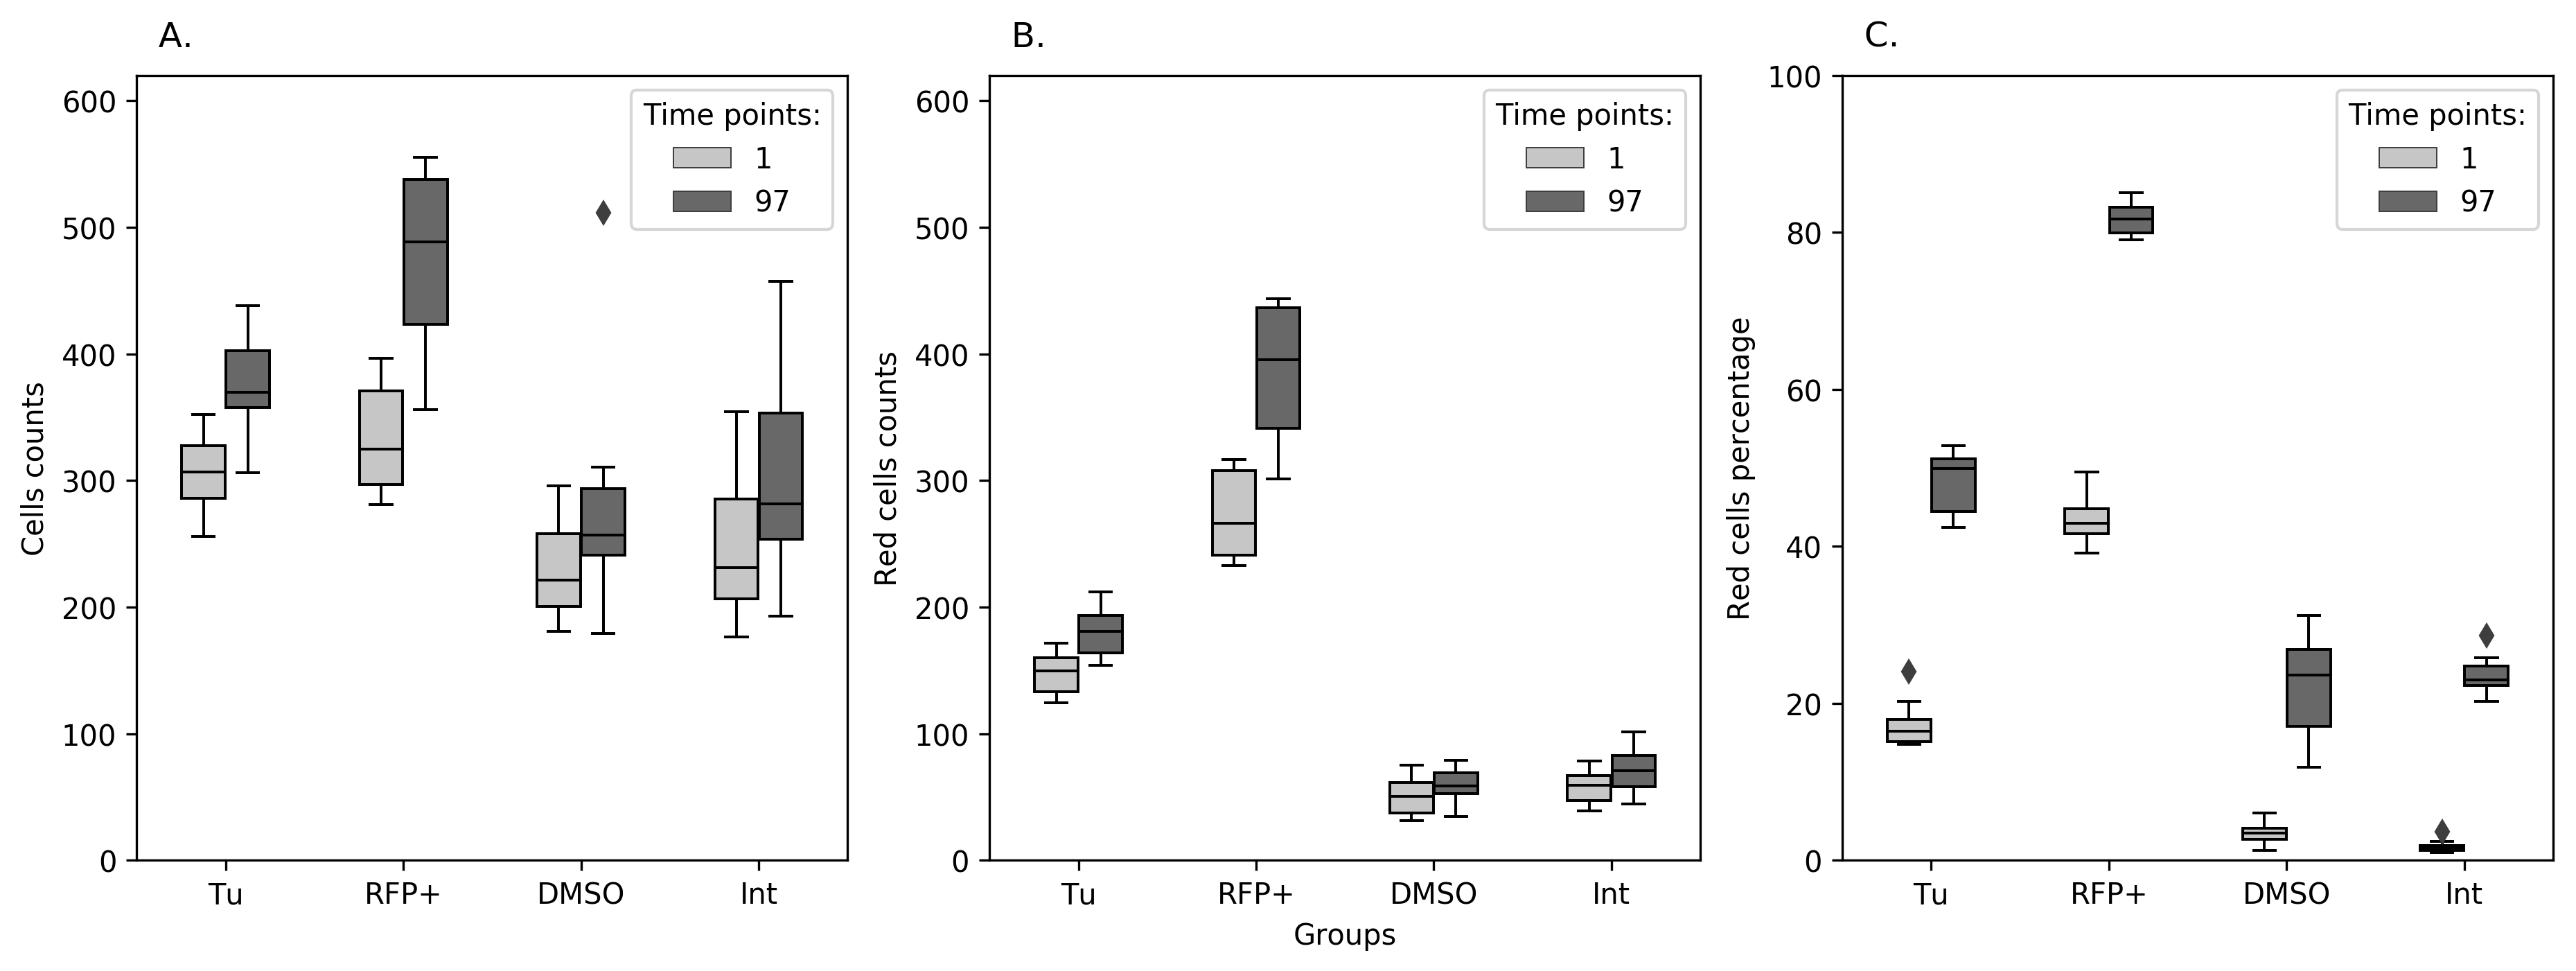

In [12]:
_, axs = plt.subplots(nrows = 1, ncols=3, figsize = (15, 5), dpi = 300 )
g = sns.boxplot(x = 'Group', y = 'Cells', 
                 data = pd.concat( [tmp_1[['Group', 'Cells','Order']],
                      tmp[['Group', 'Cells','Order']]], axis = 0), hue = 'Order',
                 linewidth = .95, width = .5, ax = axs[0], palette = 'Greys' );
g.set_xlabel('');
g.set_ylabel('Cells counts');
plt.setp(g.artists, edgecolor = 'k')
plt.setp(g.lines, color='k');

g2 = sns.boxplot(x = 'Group', y = 'Cells', 
                 data = pd.concat( [tmp4[['Group', 'Cells','Order']],
                      tmp2[['Group', 'Cells','Order']]], axis = 0), hue = 'Order',
                 linewidth = .95, width = .5, ax = axs[1], palette = 'Greys');
g2.set_xlabel('Groups');
g2.set_ylabel('Red cells counts');
plt.setp(g2.artists, edgecolor = 'k')
plt.setp(g2.lines, color='k');

g3 = sns.boxplot(x = 'Group', y = 'Red_cells_%', 
                 data = pd.concat( [tmp_1[['Group', 'Red_cells_%','Order']],
                                    tmp_97[['Group', 'Red_cells_%','Order']]], axis = 0),
                hue = 'Order', palette = 'Greys', ax = axs[2],
                linewidth = .95, width = .5);
g3.set_xlabel('');
g3.set_ylabel('Red cells percentage');
plt.setp(g3.artists, edgecolor = 'k')
plt.setp(g3.lines, color='k');

axs[0].set_ylim(0,620)
axs[1].set_ylim(0,620)
axs[2].set_ylim(0,100)

leg0 = axs[0].get_legend()
leg0.set_title('Time points:')

leg1 = axs[1].get_legend()
leg1.set_title('Time points:')

leg2 = axs[2].get_legend()
leg2.set_title('Time points:')

axs[0].set_title('  A.', pad = 10., loc = 'left');
axs[1].set_title('  B.', pad = 10., loc = 'left');
axs[2].set_title('  C.', pad = 10., loc = 'left');

## Boxplots from the paper:
## A. - total cell counts in the beginning (time point 1) at in the end of experiment (time point 97)
## B. - red cells counts in the beginning at in the end of experiment
## C. - red cells percentage in the beginning at in the end of experiment

In [13]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import (Exchangeable,
                                           Independence,Autoregressive)

In [14]:
rslt_ex1['Group_FoV'] = pd.Categorical( rslt_ex1.Group.astype('str') + '_' + rslt_ex1.FoV.astype('str') )

In [15]:
rslt_ex1['red_cells30_per1000'] = (rslt_ex1['Red_cells_%'] * 10).values.round(0).astype('int64')
rslt_ex1['red_rat30'] = rslt_ex1['Red_cells_%'] / 100

In [16]:
rslt_ex1['Group'] = pd.Categorical(rslt_ex1.Group.astype('str'),
                                   categories = ['Int','DMSO','Tu','RFP+'] )

In [17]:
rslt_ex1.dtypes

Group                  category
FoV                       int64
Date_time                object
Order                     int64
Cells                   float64
Red_cells               float64
Red_cells_%             float64
Group_FoV              category
red_cells30_per1000       int64
red_rat30               float64
dtype: object

In [18]:
fam = sm.families.Poisson()
ind = sm.cov_struct.Autoregressive()
mod = GEE.from_formula('red_cells30_per1000 ~  Group + Order', 'Group_FoV',
              time = 'Order', data = rslt_ex1,# [~rslt_sorted3050.Well.isin(['A1'])],
              cov_struct=ind, family=fam)

In [19]:
res = mod.fit(1000)

In [20]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:         red_cells30_per1000   No. Observations:                 3880
Model:                                 GEE   No. clusters:                       40
Method:                        Generalized   Min. cluster size:                  97
                      Estimating Equations   Max. cluster size:                  97
Family:                            Poisson   Mean cluster size:                97.0
Dependence structure:       Autoregressive   Num. iterations:                    44
Date:                     Sun, 22 Dec 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         23:16:54
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.4028      0.050     87.781      0.000       4.305       4.501
Group[T.DMSO]     0.1446      0.080      1.813      0.070      -0.012       0.301
Group[T.Tu]       0.9292      0.043     21.452      0.000       0.844       1.014
Group[T.RFP+]     1.6325      0.035     46.401      0.000       1.564       1.701
Order             0.0083      0.001     14.710      0.000       0.007       0.009
==============================================================================
Skew:                          0.2045   Kurtosis:                      -0.2006
Centered skew:                -0.4277   Centered kurtosis:              1.1396
==============================================================================
"""

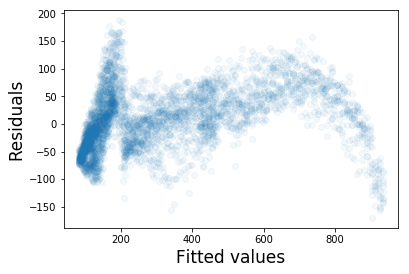

In [21]:
plt.plot(res.fittedvalues, res.resid, 'o', alpha=0.05)
plt.xlabel("Fitted values", size=17)
plt.ylabel("Residuals", size=17);

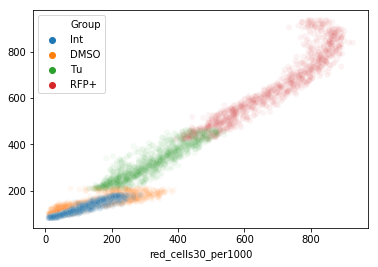

In [22]:
sns.scatterplot(x = rslt_ex1.red_cells30_per1000 ,
                y = res.fittedvalues, 
                alpha = .05, hue = rslt_ex1.Group);

In [23]:
from sinfo import sinfo
sinfo()